In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# 讀入五檔ETF資料

In [2]:
df = pd.read_csv('/Users/Kang/Desktop/ETF 2003_2019.csv', index_col = 'Date')
df = df.set_index(pd.DatetimeIndex(df.index))
title = df.columns.tolist()

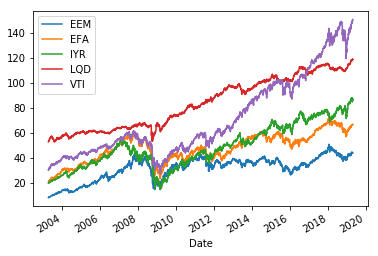

In [3]:
df.plot()

# 把CPI資料合併到ETF資料裡

In [4]:
cpi = pd.read_csv('/Users/Kang/Desktop/CPILFESL.csv', index_col = 'DATE')
cpi = cpi.set_index(pd.DatetimeIndex(cpi.index))
cpi = cpi.pct_change(12).dropna()

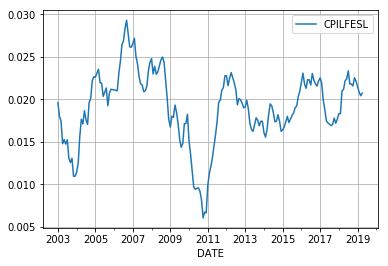

In [5]:
cpi.plot(grid=True)

In [6]:
df['CPI']  = np.nan
for i in range(len(df)):
    tem_d = df.iloc[i]
    df['CPI'].iloc[i] = cpi.loc[(cpi.index.year == tem_d.name.year) & (cpi.index.month == tem_d.name.month)].values

In [7]:
df.head()

,EEM,EFA,IYR,LQD,VTI,CPI
Date,,,,,,
2003-04-14,8.505465,20.834179,20.040634,52.943714,30.601860,0.01476
2003-04-15,8.606520,21.119843,20.126944,53.040596,30.800758,0.01476
2003-04-16,8.705894,20.980284,20.180252,53.398998,30.391888,0.01476
2003-04-17,8.768209,21.283392,20.368092,53.287613,30.863367,0.01476
2003-04-21,8.764842,21.209249,20.431545,53.398998,30.856012,0.01476


In [8]:
df.tail()

,EEM,EFA,IYR,LQD,VTI,CPI
Date,,,,,,
2019-04-24,43.770000,66.230003,86.370003,118.562660,149.600006,0.020728
2019-04-25,43.709999,66.180000,86.199997,118.503021,149.350006,0.020728
2019-04-26,43.880001,66.449997,86.849998,118.920494,150.160004,0.020728
2019-04-29,43.970001,66.720001,86.019997,118.453331,150.380005,0.020728
2019-04-30,43.930000,66.760002,87.000000,118.503021,150.389999,0.020728


# 隨機權重，將權重代入起始資料換算mean跟std並打點，找出十組權重

In [9]:
begin_invest = 10000

In [10]:
#隨機抽樣
def gen_wei(num):
    mylist = []
    for i in range(num):
        mylist.append(random.random())
    
    s = sum(mylist)
    for j in range(num):
        mylist[j] = mylist[j] / s
    
    #10次方
    mylist = [i**10 / sum(i**10 for i in mylist) for i in mylist]
    
    return mylist

In [11]:
#設計成丟入要畫效率前緣的區間，此函式只負責產生mean, std跟weights
def gen_result(dataframe, times = 10000):
    
    #把pd dataframe變成np array
    dataframe = np.array(dataframe)
    
    #先把第一筆數據生出來，存入result裡，之後產生新數據也都存在result裡
    weight = gen_wei(5)
    weight = [begin_invest * i for i in weight]
    weight = weight / dataframe[0]
    tem = sum((dataframe * weight).T)
    change = (tem[1:]/tem[:-1]) - 1
    std_mean = np.array([change.std() * math.sqrt(252), change.mean() * 252])
    result = np.append(std_mean, weight)
    result = np.array([result]) #要這樣處理，後面才能疊加
    
    #隨機次數-1，第一次已經在前面做好了
    for t in range(times - 1):
        
        #每次隨機均利用先前函數，重新生成一組權重
        weight = gen_wei(5)
        weight = [begin_invest * i for i in weight]
        weight = weight / dataframe[0]
        
        #先將各資產價格成以對應權重並加總成淨值，將之算成日變動率，近一步算std及mean，把std & mean & weight合在一起，存入result
        tem = sum((dataframe * weight).T)
        change = (tem[1:]/tem[:-1]) - 1 #後一日除以前一日減一
        std_mean = np.array([change.std() * math.sqrt(252), change.mean() * 252])
        tem_2 = np.append(std_mean, weight)
        tem_2 = np.array([tem_2]) #要這樣處理，才能跟前面疊加
        result = np.concatenate((result, tem_2), axis=0) #疊加方式
    
    #加入進位到小數點以下第三位的std
    std_round = np.round(result.T[0], 3)
    std_round = np.array([std_round])
    result = np.append(result, std_round.T, axis=1)
    #result = np.concatenate((result.T, std_round), axis=0).T #兩種寫法
     
    return result

In [12]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def scatter_graph(months = 6, times = 10000):
    plt.figure(figsize=(12,9))

    result =  gen_result(df[title][:21 * months], times) #先測試以6個月來畫效率前緣
    
    ten_quantile = []
    #把進位到小數點第三位的std分成10個quantile
    #ten_std_quantile = np.percentile(result.T[-1], [0, 11, 22, 33, 44, 55, 66, 77, 88, 100], axis=0, interpolation = 'nearest')
    
    #這種方法可以比分散比較平均
    ten_std_quantile = []
    for i in range(10):
        find = result.T[-1].min() + ((result.T[-1].max() - result.T[-1].min())/9) * i
        ten_std_quantile.append(find_nearest(result.T[-1], find))
    ten_std_quantile = np.array(ten_std_quantile)
    
    for i in range(10):
        #每個quantile下有多個點
        tem = result[np.where((result.T[-1] == ten_std_quantile[i]))]
        #該quantile下所有點中mean最大的那一行，加入資料中
        ten_quantile.append(tem[np.argmax(tem.T[1], axis=0)])
    ten_quantile = np.array(ten_quantile)

    #畫圖，最後一起print出
    plt.scatter(result.T[0], result.T[1], s = 1)
    plt.scatter(ten_quantile.T[0], ten_quantile.T[1], color = 'red')

    #產生圖之資訊
    #plt.legend(name, loc = 'best', prop = {'size' : 16})
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('Standard Deviation', size = 16)
    plt.ylabel('Expected Return', size = 16)
    plt.title(str(times) + ' times of MonteCarlo for EEM/EFA/IYR/LQD/VTI (' + str(months) +' months data)', size = 18)
    
    return result, ten_quantile

In [13]:
#result, ten_quantile = scatter_graph(6, 50000)

# 根據找出的權重，一組組逐日開始並滾十年，記下價值分配並統整出結果

In [14]:
def Income_Portfolio_Result(d_yield, months = 6, times = 50000):
    
    result, ten_quantile = scatter_graph(months, times)
    
    #可以根據先前用多少個月來畫效率前緣，此處使用多少資料來產生結果
    price = np.array(df[21 * months:])

    #根據先前使用多少個月來畫效率前緣，此處訂定開始日，結束日都是2009/03/09，區間內有多少日最後就有幾筆資料，並在此區間內逐日開始觀察結果
    s_day = df.iloc[21 * months].name
    e_day = df.loc['2009-03-09'].name
    days = len(df.loc[s_day:e_day]) #在此期間內的任一天開始

    #用於儲存所有權重計算結果的dataframe，最後再output出
    output = pd.DataFrame(columns = ['Portfolio ' + str(i) for i in range(1, 11)], 
                          index = [i + ' units' for i in title] + ['Max', 'Mean', 'Min', '75 Quantile', '50 Quantile', '25 Quantile'])
    
    #10組權重分別下去算
    for each in range(10):
        weight = ten_quantile[each][2:7] #第一到十組權重
        all_nav = sum((price.T[:-1].T * weight).T) #由於price裡面含五檔etf及cpi資訊，先將它轉置，排除最後一行cpi，再轉置回來，則price還是可以保存cpi

        #區間內一日日開始，並往後推衍十年，不記錄逐日價格，只記下第十年那天的淨值是多少
        data = []
        for i in range(days):
            tem_price = all_nav[i] #第一日
            for j in range(1, 21 * 12 * 10): #10年一天天跑
                tem_price *= (all_nav[i + j] / all_nav[i + j - 1])
                #若符合條件，就要除息，並採用price裡的cpi資料
                if (j >= 20) & (j % 21 == 0): #如果在新的月的第一天，第一個月不用
                    tem_price -= begin_invest * (d_yield/12) * ((1 + price.T[-1][i + j]) ** ((j-21)/252))
            data.append(tem_price)
        data = np.array(data)

        #五檔etf的權重分別寫入
        for j in range(5):
            output['Portfolio ' + str(each+1)].iloc[j] = ten_quantile[each][2+j]

        output['Portfolio ' + str(each+1)].loc['Max'] = np.max(data)
        output['Portfolio ' + str(each+1)].loc['Mean'] = np.mean(data)
        output['Portfolio ' + str(each+1)].loc['Min'] = np.min(data)
        output['Portfolio ' + str(each+1)].loc['75 Quantile'] = np.percentile(data, 75, interpolation = 'nearest')
        output['Portfolio ' + str(each+1)].loc['50 Quantile'] = np.percentile(data, 50, interpolation = 'nearest')
        output['Portfolio ' + str(each+1)].loc['25 Quantile'] = np.percentile(data, 25, interpolation = 'nearest')
    
    return output

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,129.059,258.575,391.623,416.629,560.534,687.338,733.576,904.796,1048.02,1175.71
EFA units,0.0971404,0.0766203,5.51627,10.56,4.72517,6.51181e-10,21.3645,0.000296434,0.00072675,1.20969e-12
IYR units,114.106,166.192,140.261,207.04,172.529,151.69,165.394,114.981,54.1927,9.57968e-12
LQD units,124.916,84.4012,70.7016,39.422,31.6489,21.0394,0.0167917,5.76306e-10,4.34743e-14,2.76933e-10
VTI units,2.48471e-18,1.63067e-06,3.70941e-06,1.12256e-06,0.0245968,1.64995e-06,8.90089e-06,8.25511e-10,7.97984e-07,2.44802e-08
Max,22540.8,27705.9,31123,34043,37463.2,40766.4,43229.4,46615.2,49339.3,51759.3
Mean,18852,23071,25406.2,27782.8,29894.6,31985,33707,35644.6,37052.6,38290.8
Min,15097.5,18586.8,20645.6,22267.6,23390.1,24487.7,25512.7,26247.4,26595.8,26882.4
75 Quantile,20848.7,25662.5,28203.3,30979.5,33296.5,35553.3,37525.3,39485.8,40717,41895
50 Quantile,18637,22528.1,24760.3,27087.9,29134,31118.7,32780.1,34652.2,36123.8,37443.5


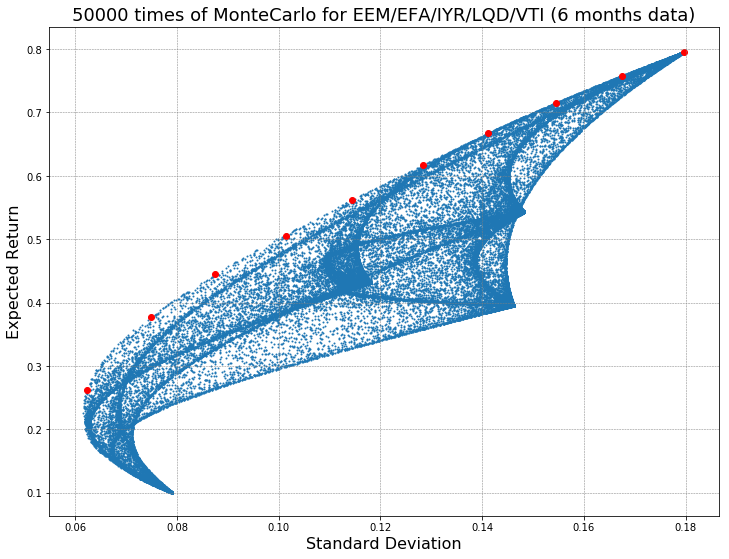

In [15]:
five_percent_six_months_IP = Income_Portfolio_Result(0.05, 6)
five_percent_six_months_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,36.122,282.128,387.13,448.822,547.992,576.791,690.485,817.14,962.788,1175.71
EFA units,0.00103225,1.56653,39.3843,77.4325,80.4703,124.203,125.894,80.7403,86.0877,2.11997e-07
IYR units,31.015,76.1378,32.7225,0.0718225,0.0238818,16.0156,0.0544101,52.5071,0.147097,1.3208e-11
LQD units,132.958,114.118,98.8023,86.2557,69.1686,41.2795,28.3864,2.35298,0.251562,5.68182e-13
VTI units,66.3974,0.00201326,4.23994e-10,0.0385159,0.000638598,0.000193181,0.00775906,6.23613,0.039583,5.07408e-13
Max,21443.4,25652.6,28657.6,30621.1,33841.2,36384.9,39571.3,44465.9,47233.3,51759.3
Mean,17640.6,21601.6,23375,24475.8,26646.2,28442,30453.9,34103.3,35548.3,38572.9
Min,14289.3,17908.9,18744.5,19206.5,20430.3,21513.4,22525.2,24835.8,25271.3,26882.4
75 Quantile,19775.2,23676.9,25606.6,26791,29246.8,31295.3,33519.8,37746.8,39286.4,42713.9
50 Quantile,17531.5,21227.2,22741.1,23786.2,25973.3,27788.7,29913.5,33354.9,35096,38181.8


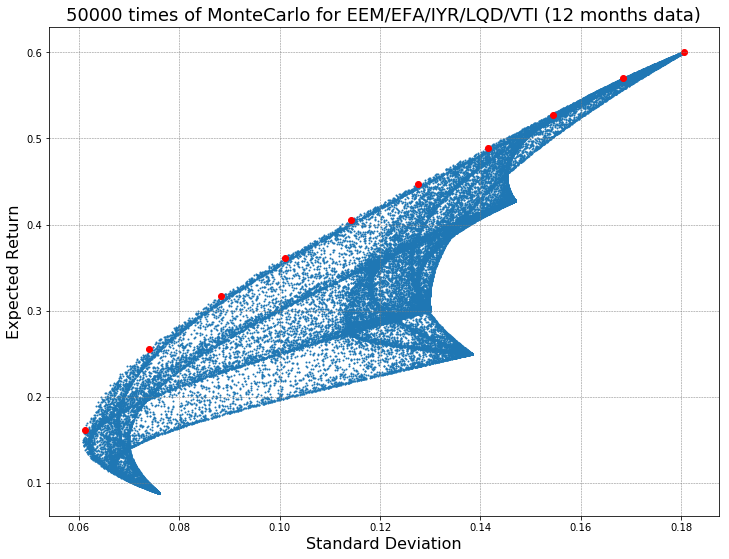

In [16]:
five_percent_one_year_IP = Income_Portfolio_Result(0.05, 12)
five_percent_one_year_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,6.48854,97.6776,133.707,201.784,288.696,339.049,628.632,847.142,1018.91,1175.71
EFA units,0.000326812,80.4424,128.734,137.635,117.509,184.283,59.1923,13.8332,2.96193e-06,3.94006e-13
IYR units,0.0757297,68.2646,67.8132,112.307,178.331,163.511,169.099,125.043,66.4443,2.15569e-07
LQD units,139.372,115.692,81.7358,51.3237,28.7558,4.52087e-21,0.587828,0.00845928,0.0357429,2.83383e-07
VTI units,83.7999,1.49845e-06,16.1515,14.6478,4.15514e-05,3.0655e-09,7.46894e-10,0.00241565,0.00690475,3.57402e-21
Max,20666.2,21622.7,25016.1,28631.3,31881.8,34798.6,40974.5,45441.6,48783.8,51759.3
Mean,17472.5,19103.3,21469.2,24297.1,27022.5,28844.5,33108.3,35720.1,37414.1,38770
Min,14403,16010.8,17375.3,19176.8,21012.7,21960.6,24617.9,25921.9,26525.4,26882.4
75 Quantile,19249.4,20597.7,23517.6,26760.2,29734.2,32019.1,36972.2,40064.4,42001.4,43577.9
50 Quantile,17404.6,19047.7,21338.6,24155.6,26904.3,28655.4,33014.7,35630.4,37504.9,38965.5


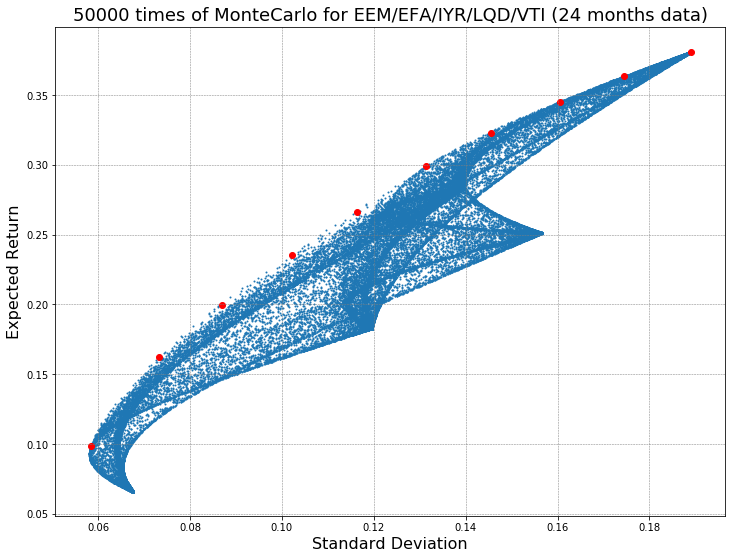

In [17]:
five_percent_two_years_IP = Income_Portfolio_Result(0.05, 24)
five_percent_two_years_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,123.871,257.985,363.739,456.956,550.142,673.2,746.157,904.924,1048.06,1175.71
EFA units,5.01945e-06,25.009,4.62989e-09,4.35938e-05,34.5915,0.0511399,20.9351,0.000698441,0.0796135,8.28975e-13
IYR units,113.299,140.287,179.214,182.167,135.973,163.756,155.346,114.827,54.0932,4.40191e-14
LQD units,126.088,84.4903,62.6072,46.5141,35.4172,18.7233,1.94062,3.36829e-05,2.61564e-06,3.77234e-11
VTI units,0.0078805,8.2207e-06,5.58126e-08,3.86382e-05,3.39638e-06,1.54706e-17,0.0472211,0.0645656,2.83027e-06,1.93394e-16
Max,19522,24323.3,28041.2,31080.1,33572.6,37413.3,40029.9,43337.6,46066.3,48489.6
Mean,15820.1,19977,22867.4,25004.3,26475,29254.9,30977.7,32975.7,34441,35725.5
Min,12095.1,15799.8,18000.9,19783.5,20695.9,22484,23419.5,24315.1,24761.2,25127.1
75 Quantile,17831.7,22469.3,25756.3,28098.9,29613.3,32805.1,34681,36744.7,38155.9,39299.8
50 Quantile,15720.3,19433.1,22200,24275.8,25671.6,28374.4,29999.2,31944,33426.2,34800.1


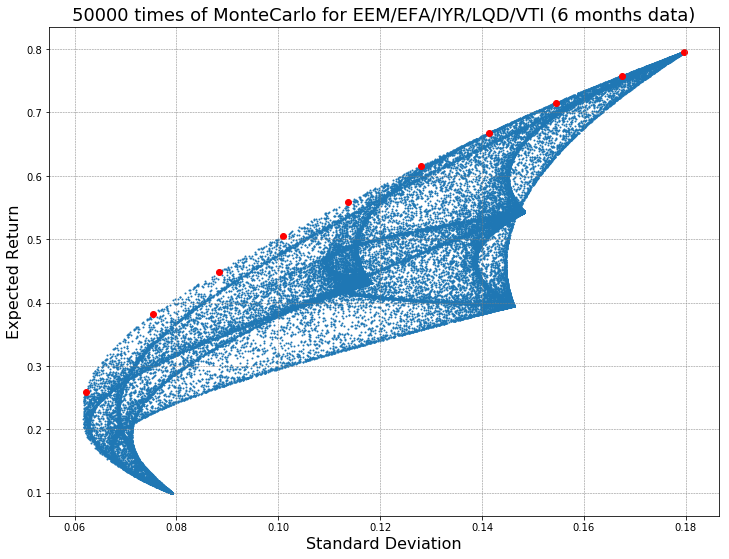

In [18]:
seven_percent_six_months_IP = Income_Portfolio_Result(0.07, 6)
seven_percent_six_months_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,8.54618e-09,300.645,388.384,474.752,543.429,700.366,700.982,780.329,961.129,1175.71
EFA units,2.77353,3.15364,1.23029e-05,37.1635,82.1147,49.4308,114.809,114.544,87.602,3.58709e-16
IYR units,48.531,36.8438,74.0274,68.1183,0.74176,5.83814e-08,7.27296,48.6211,4.15651e-05,3.82815e-11
LQD units,124.8,123.341,87.0989,72.2014,68.9007,56.9134,28.2539,0.0044763,1.57406e-11,5.46621e-12
VTI units,77.1926,3.55064,19.6628,3.99444e-07,0.142707,0.000262088,0.138613,0.0611828,0.00120285,2.13211e-11
Max,18729.3,22301.5,27021.5,29275.3,30612.9,34691.9,36613.3,40356,43942.5,48489.6
Mean,14568.4,18414,21922.9,23495.8,23996.3,26781.1,28103.8,30894.8,32981,36041.7
Min,10942.6,15138.9,17476.3,18403.9,18394.3,19999.2,20782.7,22563.3,23455.2,25127.1
75 Quantile,16687.1,20411.4,24536.6,26050.5,26486.1,29612.7,31108.9,34283,36566.6,40053.9
50 Quantile,14501.8,18005.6,21249.3,22754.3,23228.6,26012.1,27374.5,30098.6,32388.4,35454.5


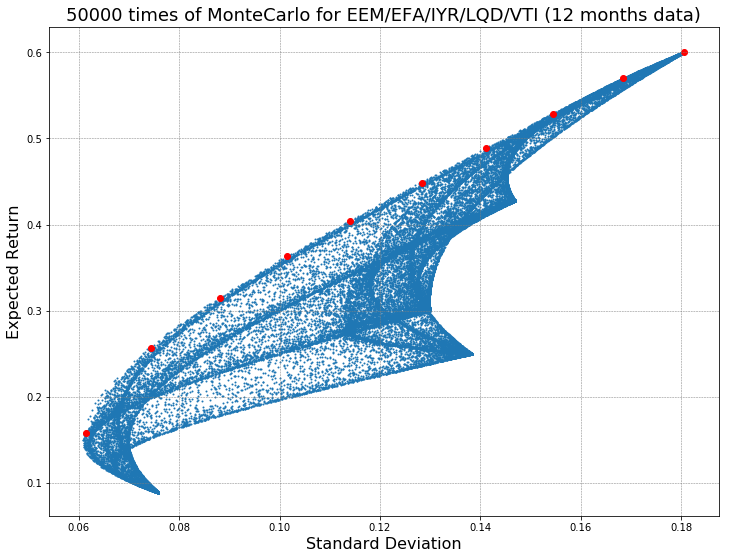

In [19]:
seven_percent_one_year_IP = Income_Portfolio_Result(0.07, 12)
seven_percent_one_year_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,4.80597e-08,100.552,226.59,220.108,115.107,344.784,604.309,838.888,1015.23,1175.71
EFA units,6.44614e-06,66.4879,52.4974,163.483,250.689,176.127,99.1509,28.9565,1.41521,4.54644e-07
IYR units,12.999,78.0675,103.74,63.3042,138.854,168.767,139.434,112.85,66.6324,3.79917e-11
LQD units,139.148,116.162,92.5511,60.4344,19.1778,0.245159,1.60292e-09,4.62882e-06,0.00288295,2.3337e-30
VTI units,77.5272,1.46979,1.28779e-07,8.28639,3.05722e-10,0.0922212,1.5401e-05,5.67209e-08,1.13304e-07,1.02346e-08
Max,17476.6,18998.5,22890,24804.5,25298.3,31611.1,37052.9,41921.9,45434,48489.6
Mean,14268.2,16440.9,19671.3,20722.1,21518.1,26184.2,29734,32843.6,34827.3,36300.8
Min,11403,13620.1,15823.4,16307.4,16829.9,19856.3,22029.7,23756.8,24646.4,25127.1
75 Quantile,15911.5,17856.3,21554.9,22939.6,23711.8,29146.5,33277.9,36913.8,39175.1,40895.7
50 Quantile,14193.8,16366.4,19594.8,20539.3,21310.5,26007.6,29566.9,32706.9,34770.9,36458.1


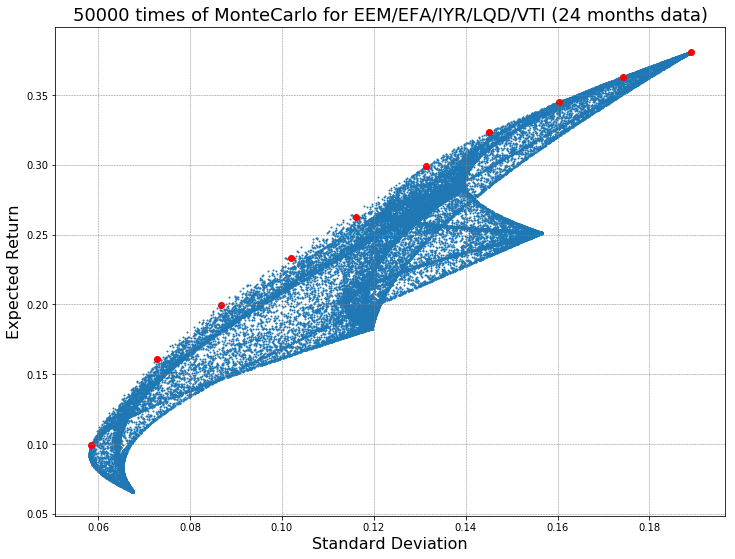

In [20]:
seven_percent_two_years_IP = Income_Portfolio_Result(0.07, 24)
seven_percent_two_years_IP

In [21]:
#five_percent_six_months_IP.to_csv('/Users/Kang/Desktop/five_percent_six_months_IP.csv')
#five_percent_one_year_IP.to_csv('/Users/Kang/Desktop/five_percent_one_year_IP.csv')
#five_percent_two_years_IP.to_csv('/Users/Kang/Desktop/five_percent_two_years_IP.csv')
#seven_percent_six_months_IP.to_csv('/Users/Kang/Desktop/seven_percent_six_months_IP.csv')
#seven_percent_one_year_IP.to_csv('/Users/Kang/Desktop/seven_percent_one_year_IP.csv')
#seven_percent_two_years_IP.to_csv('/Users/Kang/Desktop/seven_percent_two_years_IP.csv')